Title: Source Reconstruct of Spherical Power-Law Lens

Date: 08/03/2020

Obj: Using the MGE formalism to reconstruct que the original source galaxy deflected by a Spherical Power-Law (SPL) mass model

In [1]:
import autolens as al
import autolens.plot as aplt
from pyprojroot import here
import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.constants import G, M_sun, c
import astropy.units as u

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

Workspace Path:  /home/carlos/autolens_workspace


In [2]:
#Lens parameters

z_lens = 0.035
z_source = 2.1

D_l = cosmo.angular_diameter_distance(z_lens)
D_s = cosmo.angular_diameter_distance(z_source)
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

#Useful constants
metre2Mpc = (1*u.m).to(u.Mpc)/u.m           #Constant factor to convert metre to Mpc.
kg2Msun = (1*u.kg/M_sun)*u.solMass/u.kg     #Constant factor to convert kg to Msun

G_Mpc = G*(metre2Mpc)**3/kg2Msun            #Gravitational constant in Mpc³/(Msun s²)
c_Mpc = c*metre2Mpc                         #Speed of light in Mpc/s

#MGE parameters
#Reading data
Surf_mge, sigma, qObs = np.loadtxt('SPL MGE.txt', unpack=True)

#Converting and computing some quantities
Surf_mge = Surf_mge*(u.solMass/u.pc**2)                        #Surface Density in M_sun/pc²
sigma = sigma*u.arcsec                                         #Sigma in arcsec
sigma_pc = (sigma*D_l).to(u.pc, u.dimensionless_angles())      #Convert sigma in arcsec to sigma in pc
Mass_mge = 2*np.pi*Surf_mge*(sigma_pc**2)*qObs                 #Total mass per gaussian component in M_sun




#Defining inputs for the integral below
i = np.deg2rad(90)*u.rad                                       #Inclination angle in rad
M0 = Mass_mge                                                  #Mass per gaussian component in M_sun
q0 = np.sqrt(qObs**2 - np.cos(i)**2)/np.sin(i)                 #Deprojected axial ratio
sigma0 = (sigma).to(u.rad)                                     #Sigma per gaussian in rad

M0.sum()

<Quantity 9.59525046e+10 solMass>

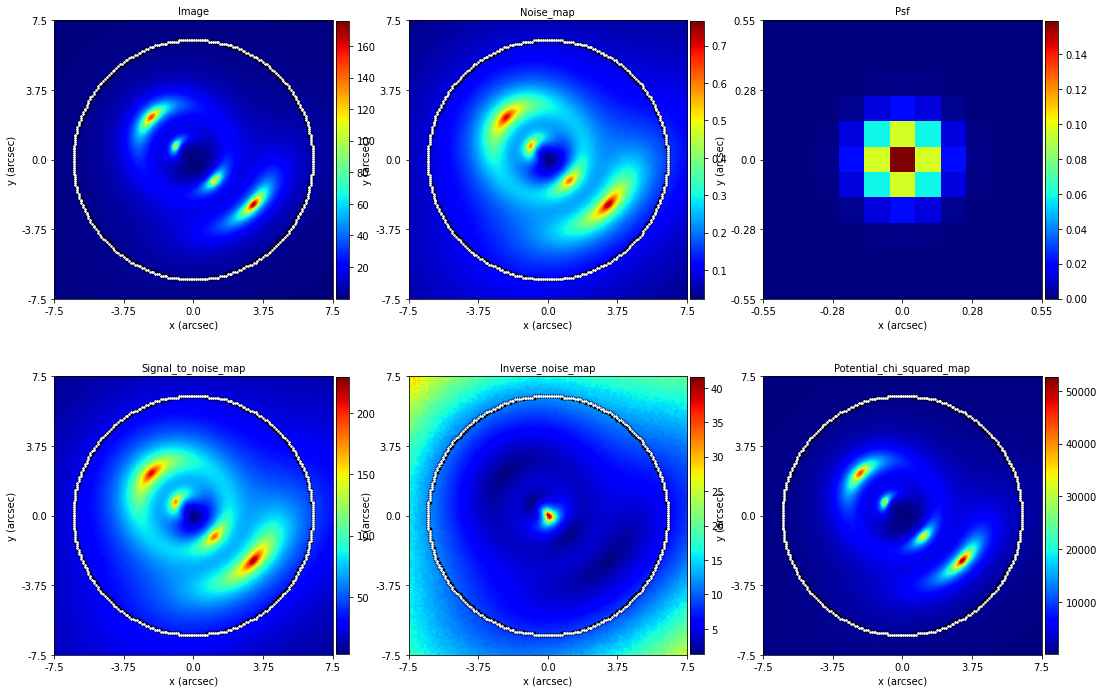

In [3]:
#Reading simulated data
dataset_type = "Testes with MGE/Spherical Power-Law"
dataset_name = "Data"
dataset_path = f"{workspace_path}/howtolens/{dataset_type}/{dataset_name}"

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/ImageSPL.fits",
    noise_map_path=f"{dataset_path}/NoiseSPL.fits",
    psf_path=f"{dataset_path}/PsfSPL.fits",
    pixel_scales=0.1,
)

mask = al.Mask.circular(
    shape_2d=imaging.shape_2d, pixel_scales=imaging.pixel_scales, sub_size=1,radius=6.5 ,centre=(0., 0)
)

masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

aplt.Imaging.subplot_imaging(
    imaging=imaging, mask=mask, include=aplt.Include(border=True)
)


__Defining the MGE mass model for the lens galaxy and performing the ray tracing__

In [4]:
time = clock()

mass_profile = al.mp.MGE(centre=(0.0, 0.0))
mass_profile.MGE_comps(M=M0.value, sigma=sigma0.value, q=q0.value, z_l=z_lens, z_s=z_source)
    
lens_galaxy = al.Galaxy(
        redshift=0.035,
        mass=mass_profile,
    )

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=2.1)])
source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_imaging.grid)[1]

print(lens_galaxy)

print(clock() - time)

/home/carlos/anaconda3/lib/python3.7/site-packages/autogalaxy/profiles/mass_profiles/total_mass_profiles.py:159: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  grid_def[i,0] = ((const_factor*integrate.quad(alpha_y, 0, 1, args=(yrad.value, xrad.value, self.M, self.sigma, self.q))[0]*(u.solMass*u.rad)).to(u.arcsec)).value
/home/carlos/anaconda3/lib/python3.7/site-packages/autogalaxy/profiles/mass_profiles/total_mass_profiles.py:160: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  grid_def[i,1] = ((const_factor*integrate.quad(alpha_x, 0, 1, args=(yrad.value,

Redshift: 0.035
Mass Profiles:
MGE
centre: (0.0, 0.0)
M: [6.92296034e+07 6.79941021e+07 6.94413524e+07 7.54797877e+07
 8.51553254e+07 9.72782576e+07 1.11480540e+08 1.27903539e+08
 1.46847574e+08 1.68666696e+08 1.93768891e+08 2.22628120e+08
 2.55791468e+08 2.93887812e+08 3.37640159e+08 3.87876745e+08
 4.45550251e+08 5.11752911e+08 5.87735431e+08 6.74926462e+08
 7.74951631e+08 8.89648988e+08 1.02108665e+09 1.17156876e+09
 1.34364377e+09 1.54007827e+09 1.76381937e+09 2.01793610e+09
 2.30554282e+09 2.62972973e+09 2.99359038e+09 3.40049443e+09
 3.85479866e+09 4.36327419e+09 4.93869834e+09 5.61581364e+09
 6.51239477e+09 7.99267018e+09 1.13167357e+10 2.45749932e+10]
sigma: [4.76368615e-15 9.77492010e-15 1.77990956e-14 3.06066755e-14
 5.15615834e-14 8.63399352e-14 1.44289618e-13 2.40934316e-13
 4.02191346e-13 6.71377743e-13 1.12089165e-12 1.87174006e-12
 3.12617509e-12 5.22221905e-12 8.72476033e-12 1.45776299e-11
 2.43575872e-11 4.06982275e-11 6.79973489e-11 1.13596694e-10
 1.89748172e-10 3.16

__Rectangular Inversion__

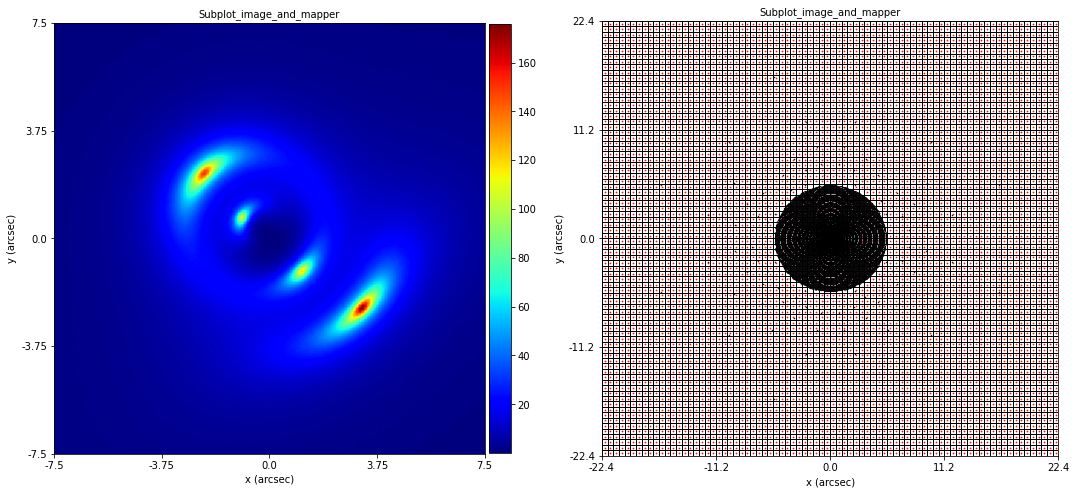

0.5516907960000026


In [5]:
time = clock()

rectangular = al.pix.Rectangular(shape=(80, 80))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=False, inversion_grid=True),
)

print(clock() - time)

In [6]:
time = clock()

inversion = al.Inversion(
    masked_dataset=masked_imaging,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=8.0),
)

print(clock() - time)


4.6400170299998535


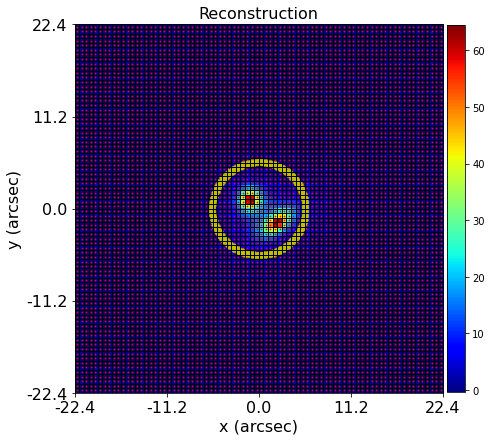

In [80]:
aplt.Inversion.reconstruction(inversion=inversion)

In [7]:
#Defining some output configs

sub_plotter = aplt.SubPlotter(output=aplt.Output(path='/home/carlos/autolens_workspace/howtolens/Testes with MGE/Spherical Power-Law/Image Output/Rectangular Reconstruction/',
                                          filename='Rectangular Inversion Plots',
                                          format='png'),        
                              )

plotter = aplt.Plotter(output=aplt.Output(path='/home/carlos/autolens_workspace/howtolens/Testes with MGE/Spherical Power-Law/Image Output/Rectangular Reconstruction/',
                                          format='png'),         
                          )

include = aplt.Include(inversion_grid=False,
                       inversion_pixelization_grid=False,
                       inversion_border=True,
                       inversion_image_pixelization_grid=False,
                      )


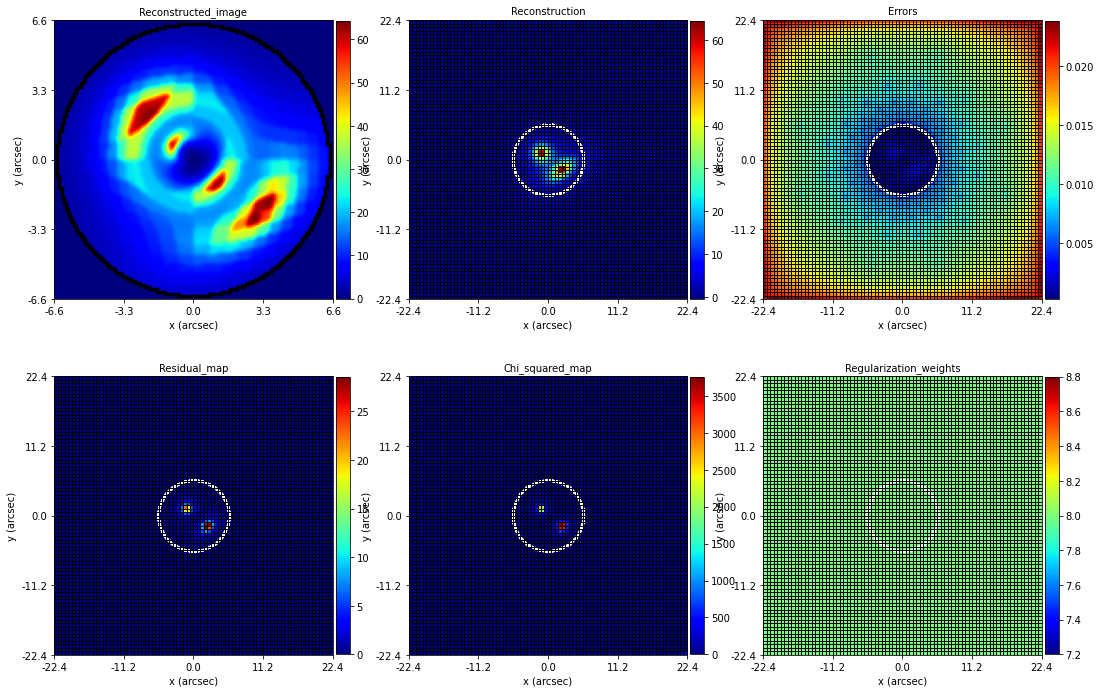

In [8]:
#Ploting Results
aplt.Inversion.subplot_inversion(inversion=inversion,
                                include=(
                                     aplt.Include(
                                               inversion_grid=False, 
                                               inversion_pixelization_grid=False, 
                                               inversion_image_pixelization_grid=False)
                                         ),
                                 sub_plotter=sub_plotter
                                )
 
aplt.Inversion.subplot_inversion(inversion=inversion,
                                include=(
                                     aplt.Include(
                                               inversion_grid=False, 
                                               inversion_pixelization_grid=False, 
                                               inversion_image_pixelization_grid=False)
                                         ),
                                )

In [9]:
#Save image results
aplt.Inversion.individuals(inversion=inversion, 
                           plotter=plotter,
                           include=include,
                           plot_interpolated_reconstruction=True, 
                           plot_errors=True,
                           plot_reconstruction=True, 
                           plot_residual_map=True, 
                           plot_chi_squared_map=True,
                           plot_normalized_residual_map=True,
                               )

####################################################################################################################

In [9]:
#Here we define an usulfull function
def fit_masked_imaging_with_source_galaxy(masked_imaging, source_galaxy):
    mass_profile = al.mp.MGE(centre=(0.0, 0.0))
    mass_profile.MGE_comps(M=M0.value, sigma=sigma0.value, q=q0.value, z_l=z_lens, z_s=z_source)
    
    lens_galaxy = al.Galaxy(
        redshift=0.035,
        mass=mass_profile,
    )

    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

    return al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)


__Inversion with Constante Voronoi__

/home/carlos/anaconda3/lib/python3.7/site-packages/autogalaxy/profiles/mass_profiles/total_mass_profiles.py:159: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  grid_def[i,0] = ((const_factor*integrate.quad(alpha_y, 0, 1, args=(yrad.value, xrad.value, self.M, self.sigma, self.q))[0]*(u.solMass*u.rad)).to(u.arcsec)).value
/home/carlos/anaconda3/lib/python3.7/site-packages/autogalaxy/profiles/mass_profiles/total_mass_profiles.py:160: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  grid_def[i,1] = ((const_factor*integrate.quad(alpha_x, 0, 1, args=(yrad.value,

Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model


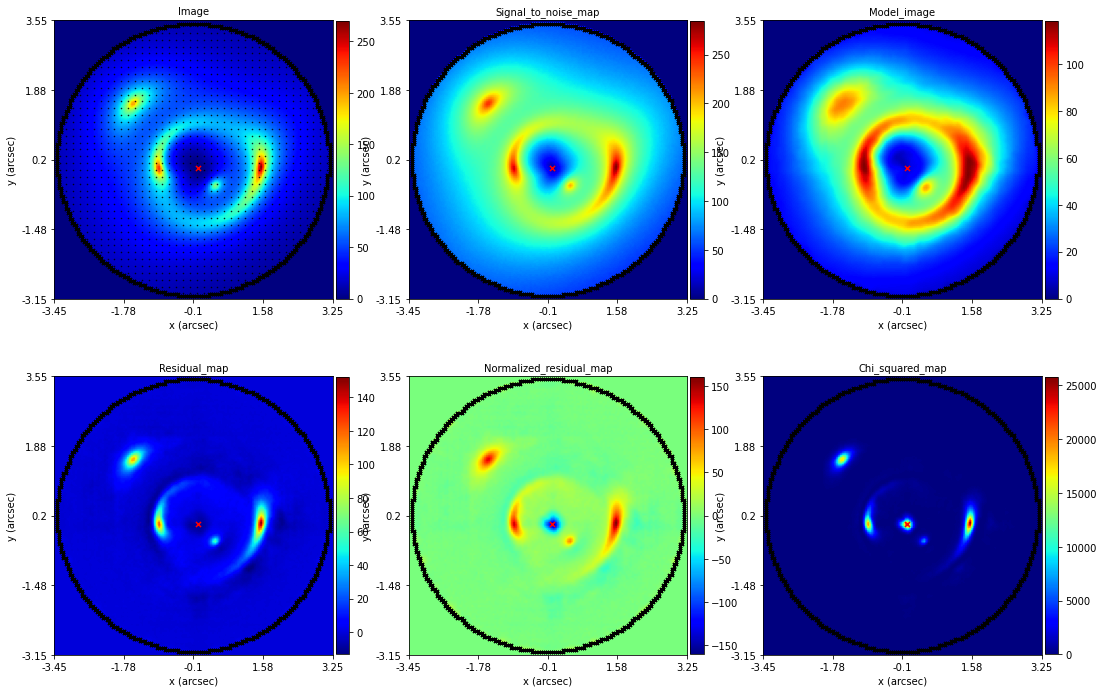

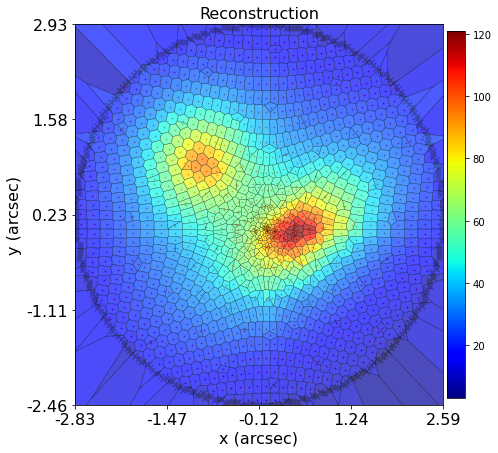

Evidence using adaptive _Regularization_=  -3689653.6514063217


In [10]:
time = clock(
)
source_magnification = al.Galaxy(
    redshift=2.1,
    pixelization=al.pix.VoronoiMagnification(shape=(25, 25)),
    regularization=al.reg.Constant(coefficient=7),
)

fit = fit_masked_imaging_with_source_galaxy(
    masked_imaging=masked_imaging, source_galaxy=source_magnification
)

print(clock() - time)

In [ ]:
sub_plotter = aplt.SubPlotter(output=aplt.Output(path='/home/carlos/autolens_workspace/howtolens/Testes with MGE/Spherical Power-Law/Image Output/ConstVoronoi/',
                                          filename='Constant Voronoi Plots',
                                          format='png'),        
                              )


plotter = aplt.Plotter(output=aplt.Output(path='/home/carlos/autolens_workspace/howtolens/Testes with MGE/Spherical Power-Law/Image Output/ConstVoronoi/',
                                          format='png'),         
                       )


include = aplt.Include(inversion_grid=False,
                       inversion_pixelization_grid=False,
                       inversion_border=True,
                       inversion_image_pixelization_grid=False,
                      )

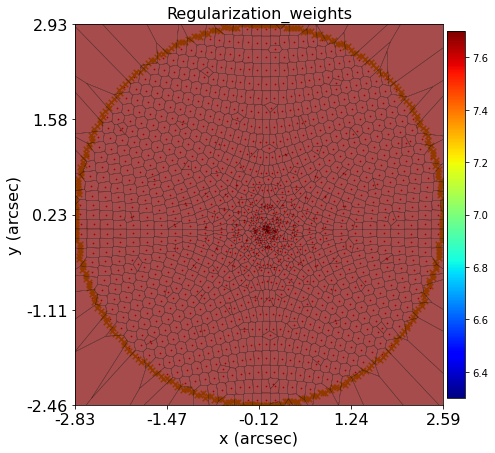

In [11]:
aplt.FitImaging.subplot_fit_imaging(fit=fit, 
                                    include=aplt.Include(inversion_image_pixelization_grid=True, mask=True),
                                    sub_plotter=sub_plotter, 
                                    )



aplt.Inversion.individuals(inversion=fit.inversion, 
                           plotter=plotter,
                           include=include,
                           plot_interpolated_reconstruction=True, 
                           plot_errors=True,
                           plot_reconstruction=True, 
                           plot_residual_map=True, 
                           plot_chi_squared_map=True,
                           plot_normalized_residual_map=True,
                           plot_regularization_weight_map=True,
                               )

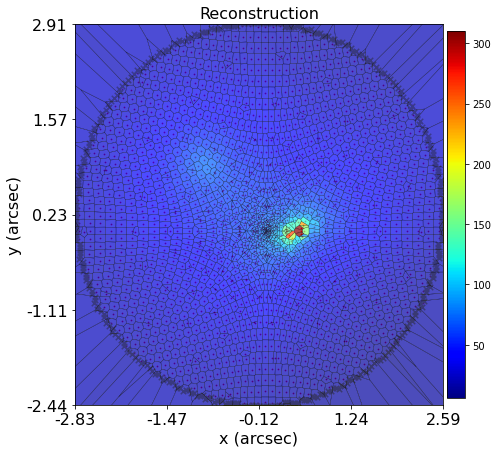

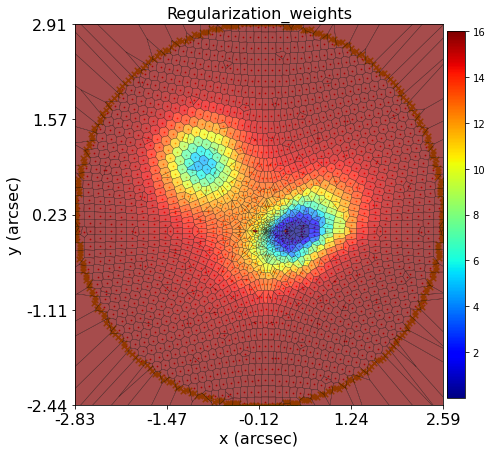

In [12]:
aplt.FitImaging.subplot_fit_imaging(fit=fit, 
                                    include=aplt.Include(inversion_image_pixelization_grid=True, mask=True),
                                    )

aplt.Inversion.individuals(inversion=fit.inversion,
                           include=aplt.Include(inversion_pixelization_grid=False),
                           plot_reconstruction=True, 
                           plot_regularization_weight_map=True,
                           plotter=aplt.Plotter(figure=aplt.Figure(figsize=(7,7)))
                               
                           )

print("Evidence using adaptive _Regularization_= ", fit.log_evidence)
frist_log = fit.log_evidence

#################################################################################################################

__Inversion with Adaptative Voronoi__

In [ ]:
hyper_image = fit.model_image.in_1d_binned

source_adaptive_regularization = al.Galaxy(
    redshift=2.1,
    pixelization=al.pix.VoronoiMagnification(shape=(50, 50)),
    regularization=al.reg.AdaptiveBrightness(
        inner_coefficient=0.05, outer_coefficient=4, signal_scale=3.0
    ),
    hyper_galaxy_image=hyper_image,
)

fit = fit_masked_imaging_with_source_galaxy(
    masked_imaging=masked_imaging, source_galaxy=source_adaptive_regularization
)

In [ ]:
sub_plotter = aplt.SubPlotter(output=aplt.Output(path='/home/carlos/autolens_workspace/howtolens/Testes with MGE/Spherical Power-Law/Image Output/AdaptativeVoronoi/',
                                          filename='Adaptative Voronoi Plots',
                                          format='png'),        
                              )


plotter = aplt.Plotter(output=aplt.Output(path='/home/carlos/autolens_workspace/howtolens/Testes with MGE/Spherical Power-Law/Image Output/AdaptativeVoronoi/',
                                          format='png'),         
                       )


include = aplt.Include(inversion_grid=False,
                       inversion_pixelization_grid=False,
                       inversion_border=True,
                       inversion_image_pixelization_grid=False,
                      )

In [ ]:
aplt.FitImaging.subplot_fit_imaging(fit=fit, 
                                    include=aplt.Include(inversion_image_pixelization_grid=True, mask=True),
                                    sub_plotter=sub_plotter, 
                                    )



aplt.Inversion.individuals(inversion=fit.inversion, 
                           plotter=plotter,
                           include=include,
                           plot_interpolated_reconstruction=True, 
                           plot_errors=True,
                           plot_reconstruction=True, 
                           plot_residual_map=True, 
                           plot_chi_squared_map=True,
                           plot_normalized_residual_map=True,
                           plot_regularization_weight_map=True,
                               )

In [ ]:
aplt.FitImaging.subplot_fit_imaging(fit=fit, 
                                    include=aplt.Include(inversion_image_pixelization_grid=True, mask=True),
                                    )

aplt.Inversion.individuals(inversion=fit.inversion,
                           include=aplt.Include(inversion_pixelization_grid=False),
                           plot_reconstruction=True, 
                           plot_regularization_weight_map=True,
                           plotter=aplt.Plotter(figure=aplt.Figure(figsize=(7,7)))
                               
                           )

print("Evidence using adaptive _Regularization_= ", fit.log_evidence)

In [ ]:
print("Evidence using constant _Regularization_= ", frist_log)
print("Evidence using adaptive _Regularization_= ", fit.log_evidence)

#################################################################################################################

__Adaptative Voronoi with different regularizations__

In [ ]:
source_adaptive_regularization = al.Galaxy(
    redshift=2.1,
    pixelization=al.pix.VoronoiMagnification(shape=(40, 40)),
    regularization=al.reg.AdaptiveBrightness(
        inner_coefficient=0.001, outer_coefficient=0.2, signal_scale=2.0
    ),
    hyper_galaxy_image=hyper_image,
)

fit = fit_masked_imaging_with_source_galaxy(
    masked_imaging=masked_imaging, source_galaxy=source_adaptive_regularization
)

In [ ]:
sub_plotter = aplt.SubPlotter(output=aplt.Output(path='/home/carlos/autolens_workspace/howtolens/Testes with MGE/Spherical Power-Law/Image Output/AdaptativeVoronoi2/',
                                          filename='Adaptative Voronoi Plots',
                                          format='png'),        
                              )


plotter = aplt.Plotter(output=aplt.Output(path='/home/carlos/autolens_workspace/howtolens/Testes with MGE/Spherical Power-Law/Image Output/AdaptativeVoronoi2/',
                                          format='png'),         
                       )


include = aplt.Include(inversion_grid=False,
                       inversion_pixelization_grid=False,
                       inversion_border=True,
                       inversion_image_pixelization_grid=False,
                      )

In [ ]:
aplt.FitImaging.subplot_fit_imaging(fit=fit, 
                                    include=aplt.Include(inversion_image_pixelization_grid=True, mask=True),
                                    sub_plotter=sub_plotter, 
                                    )



aplt.Inversion.individuals(inversion=fit.inversion, 
                           plotter=plotter,
                           include=include,
                           plot_interpolated_reconstruction=True, 
                           plot_errors=True,
                           plot_reconstruction=True, 
                           plot_residual_map=True, 
                           plot_chi_squared_map=True,
                           plot_normalized_residual_map=True,
                           plot_regularization_weight_map=True,
                               )

In [ ]:
aplt.FitImaging.subplot_fit_imaging(fit=fit, 
                                    include=aplt.Include(inversion_image_pixelization_grid=True, mask=True),
                                    )

aplt.Inversion.individuals(inversion=fit.inversion,
                           include=aplt.Include(inversion_pixelization_grid=False),
                           plot_reconstruction=True, 
                           plot_regularization_weight_map=True,
                           plotter=aplt.Plotter(figure=aplt.Figure(figsize=(7,7)))
                               
                           )

print("Evidence using adaptive _Regularization_= ", fit.log_evidence)